## SENTIMENT ANALYSIS with TWEEPY and VaderSentiment

- I want to analyze whether the general notion of Joe Bidden's tweets is good or bad.
- I would have liked to make a comparison between Trump's and Biden's tweets but "unfortunately", Trump was banned from the social network until 2023.

In [1]:
import tweepy
from tweepy import Stream
from tweepy.streaming import StreamListener
import json
import logging
import re
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from textblob import TextBlob
import matplotlib.pyplot as plt

from config_boris import Twitter  


### AUTHENTICATION

In [2]:
#Twitter API credentials
consumer_key = Twitter['consumer_key']                 #import consumer_key, saved in Twitter file in the same folder
consumer_secret = Twitter['consumer_secret']
access_token = Twitter['access_token']
access_token_secret = Twitter['access_token_secret']

AUTH = tweepy.OAuthHandler(consumer_key, consumer_secret)

# user authentification
AUTH.set_access_token(Twitter['access_token'], Twitter['access_token_secret'])

### ACCESING REST API (no streaming)

In [3]:
#create API object
api = tweepy.API(AUTH, wait_on_rate_limit=True)

posts = api.user_timeline(screen_name = 'JoeBiden', count= 200, lang ='en',tweet_mode="extended")
            
    #200 is the limit count, maybe we can repeat the same more than one time
    #we should put extended on tweet_mode to see the whole text
        
 
for tweet in posts[0:5]:
    print(tweet.full_text + '\n')
    print(tweet.created_at)                     

RT @POTUS: Juneteenth is officially a federal holiday.

2021-06-17 22:52:03
It’s a big deal that the Affordable Care Act is here to stay. Reminder: You can sign up for health care at https://t.co/3CYKhP8ZoR—help us spread the word.

2021-06-17 17:55:46
We're on the right track. The American Rescue Plan laid a strong foundation for a new economy that brings everybody along, but it's just the first step. We must pass the American Jobs Plan to build an economy that works for everyone.

2021-06-16 21:14:26
RT @POTUS: Today we passed a grim milestone: 600,000 lives lost from COVID-19. My heart goes out to all those who’ve lost a loved one. I kn…

2021-06-16 00:01:22
We’re seeing a coordinated attack on voting rights in this country. It’s Jim Crow in the 21st century, and it must end.

Congress must enact legislation to make it easier for all eligible Americans to access the ballot box and prevent attacks on the sacred right to vote.

2021-06-15 21:23:11


### INSERT TWEETS ON DATAFRAME

In [4]:
df = pd.DataFrame([tweet.full_text for tweet in posts],[tweet.created_at for tweet in posts], columns=['Tweets'])


In [5]:
df.head()

,Tweets
2021-06-17 22:52:03,RT @POTUS: Juneteenth is officially a federal ...
2021-06-17 17:55:46,It’s a big deal that the Affordable Care Act i...
2021-06-16 21:14:26,We're on the right track. The American Rescue ...
2021-06-16 00:01:22,RT @POTUS: Today we passed a grim milestone: 6...
2021-06-15 21:23:11,We’re seeing a coordinated attack on voting ri...


In [6]:
df

,Tweets
2021-06-17 22:52:03,RT @POTUS: Juneteenth is officially a federal ...
2021-06-17 17:55:46,It’s a big deal that the Affordable Care Act i...
2021-06-16 21:14:26,We're on the right track. The American Rescue ...
2021-06-16 00:01:22,RT @POTUS: Today we passed a grim milestone: 6...
2021-06-15 21:23:11,We’re seeing a coordinated attack on voting ri...
...,...
2021-03-03 14:43:25,RT @POTUS: An educator is leading the Departme...
2021-03-02 22:14:30,"RT @WhiteHouse: Today, President Biden announc..."
2021-03-02 21:46:55,"RT @POTUS: Today, I am directing every state t..."
2021-03-02 18:36:24,RT @POTUS: The fact is that $600 is not enough...


### CLEANING DATA

We use REGULAR EXPRESSIONS (re) to remove:
- Mentions
- Hashtags
- RT
- Links

In [7]:
#create a function to clean tweets
def cleantext(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)     #sub mentions with empty string
    text = re.sub(r'#', '', text)                 #remove # symbol
    text = re.sub(r'RT[\s]+', '', text)           #remove RT (\s means whitespace )   
    text = re.sub(r'https?:\/\/\S+', '', text)    #remove hyperlink (? removes http and https; S represents a non-whitespace)
    
    return text

#When an "r" or "R" prefix is present, a character following a backslash is included in the string without change, and all backslashes are left in the string. 
#For example, the string literal r"\n" consists of two characters: a backslash and a lowercase "n"

In [8]:
df['Tweets']= df['Tweets'].apply(cleantext)

In [9]:
df

,Tweets
2021-06-17 22:52:03,: Juneteenth is officially a federal holiday.
2021-06-17 17:55:46,It’s a big deal that the Affordable Care Act i...
2021-06-16 21:14:26,We're on the right track. The American Rescue ...
2021-06-16 00:01:22,": Today we passed a grim milestone: 600,000 li..."
2021-06-15 21:23:11,We’re seeing a coordinated attack on voting ri...
...,...
2021-03-03 14:43:25,: An educator is leading the Department of Edu...
2021-03-02 22:14:30,": Today, President Biden announced a breakthro..."
2021-03-02 21:46:55,": Today, I am directing every state to priorit..."
2021-03-02 18:36:24,: The fact is that $600 is not enough. The Sen...


### Now, I use VaderSentiment to extract sentiments on Joe Biden's tweets

#### VADER’s SentimentIntensityAnalyzer() takes in a string and returns a dictionary of scores in each of four categories:
- negative
- neutral
- positive
- compound (computed by normalizing the scores above)

In [10]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer() 

In [11]:
df['neg'] = df['Tweets'].apply(lambda x:analyzer.polarity_scores(x)['neg'])   #https://guias.makeitreal.camp/pandas/la-funcion-lambda
df['neu'] = df['Tweets'].apply(lambda x:analyzer.polarity_scores(x)['neu'])
df['pos'] = df['Tweets'].apply(lambda x:analyzer.polarity_scores(x)['pos'])
df['compound'] = df['Tweets'].apply(lambda x:analyzer.polarity_scores(x)['compound'])
df

,Tweets,neg,neu,pos,compound
2021-06-17 22:52:03,: Juneteenth is officially a federal holiday.,0.000,0.690,0.310,0.4019
2021-06-17 17:55:46,It’s a big deal that the Affordable Care Act i...,0.000,0.789,0.211,0.7506
2021-06-16 21:14:26,We're on the right track. The American Rescue ...,0.000,0.903,0.097,0.5106
2021-06-16 00:01:22,": Today we passed a grim milestone: 600,000 li...",0.222,0.561,0.217,0.2023
2021-06-15 21:23:11,We’re seeing a coordinated attack on voting ri...,0.111,0.816,0.072,-0.4767
...,...,...,...,...,...
2021-03-03 14:43:25,: An educator is leading the Department of Edu...,0.000,0.868,0.132,0.4939
2021-03-02 22:14:30,": Today, President Biden announced a breakthro...",0.000,1.000,0.000,0.0000
2021-03-02 21:46:55,": Today, I am directing every state to priorit...",0.000,0.939,0.061,0.0772
2021-03-02 18:36:24,: The fact is that $600 is not enough. The Sen...,0.000,0.883,0.117,0.5106


In [12]:
pd.set_option('display.max_colwidth', None)


In [13]:
positive = df[df['compound'] > 0.0]
positive = positive.sort_values(by=['compound'], ascending=False)
positive

,Tweets,neg,neu,pos,compound
2021-04-04 14:37:24,": From our family to yours, we wish you health, hope, joy, and peace. Happy Easter, everyone!",0.000,0.415,0.585,0.9508
2021-06-12 18:13:25,"The COVID-19 vaccine is free, but lack of access to child care can be a barrier. That’s why four of our nation’s largest child care providers are offering free care for parents and caregivers getting vaccinated from now until July 4:",0.081,0.584,0.335,0.9501
2021-03-13 17:42:27,"The American Rescue Plan means a $7,000 check for a single mom of four. It means more support to safely and quickly reopen schools. It means setting up additional vaccination sites to help America get back to normal. \n\nWhat does the American Rescue Plan mean to you?",0.000,0.727,0.273,0.9409
2021-06-15 00:10:25,"Democracy thrives when the infrastructure of democracy is strong; when people have the right to vote freely, fairly, and conveniently; when a free and independent press pursues the truth; when the law applies equally to everyone, regardless of who they are or what they look like.",0.000,0.741,0.259,0.9231
2021-05-09 16:00:04,"To moms everywhere, wishing you a safe and happy Mother’s Day. \n\nShare your favorite quote from your mother below.",0.000,0.505,0.495,0.9136
...,...,...,...,...,...
2021-05-28 01:07:55,"This is our moment to rebuild an economy from the bottom up and the middle out—not trickle down.\n\nThis is our moment to rebuild an economy that rewards work, not just wealth.\n\nThis is our moment to rebuild an economy that works for the backbone of this country.",0.051,0.889,0.060,0.1210
2021-05-05 18:52:15,": If we want our economy to recover in a way that deals everyone in, then our restaurants need a seat at the table — with the Amer…",0.000,0.954,0.046,0.0772
2021-03-02 21:46:55,": Today, I am directing every state to prioritize educators for vaccination. We want every educator, school staff member, and chil…",0.000,0.939,0.061,0.0772
2021-05-13 19:59:41,"Today is a great day for America in our long battle with COVID-19. \n\nJust a few hours ago, the CDC announced they are no longer recommending that fully vaccinated people need to wear masks.",0.120,0.777,0.103,0.0772


In [14]:
positive.iloc[0][0]

': From our family to yours, we wish you health, hope, joy, and peace. Happy Easter, everyone! '

In [20]:
negative = df[df['compound'] < 0.0]
negative = negative.sort_values(by=['compound'], ascending=True)
negative

,Tweets,neg,neu,pos,compound
2021-03-23 17:33:46,: Jill and I are devastated for the lives that have been shattered by gun violence in Colorado. Less than a week after the horrifi…,0.393,0.607,0.000,-0.9274
2021-05-24 15:22:29,": The recent attacks on the Jewish community are despicable, and they must stop. I condemn this hateful behavior at home and abroa…",0.376,0.624,0.000,-0.8873
2021-04-12 23:56:08,": Today I’m thinking about Daunte Wright and his family — and the pain, anger, and trauma that Black America experiences every day…",0.329,0.671,0.000,-0.8689
2021-05-20 20:01:23,: Incidents of hate against Asian Americans have seen a shocking spike over the last year. It’s wrong — and it’s un-American.\n \nTo…,0.322,0.678,0.000,-0.8591
2021-04-08 21:54:05,": My Administration is taking initial steps to reduce gun violence, including:\n\n- Stopping the proliferation of ghost guns\n- Regul…",0.380,0.620,0.000,-0.8555
2021-04-20 23:19:51,": Today, a jury in Minnesota found former Minneapolis Police Officer Derek Chauvin guilty of murdering George Floyd.\n \nThe verdict…",0.283,0.717,0.000,-0.7964
2021-04-10 23:31:17,: Gun violence in this country is an epidemic — and it’s long past time Congress take action.,0.289,0.711,0.000,-0.7579
2021-04-08 16:00:19,": Today, I’m joining Vice President Harris and Attorney General Garland to announce new actions to reduce gun violence. Tune in. h…",0.245,0.755,0.000,-0.7579
2021-06-12 17:11:38,": Five years ago, we suffered the deadliest attack affecting the LGBTQ+ community in our history. Within minutes, Pulse Nightclub…",0.259,0.741,0.000,-0.7430
2021-04-21 16:30:38,": The guilty verdict does not bring back George Floyd. But through the family’s pain, they are finding purpose so George’s legacy…",0.238,0.713,0.049,-0.7227


In [16]:
negative.iloc[0][0]

': Jill and I are devastated for the lives that have been shattered by gun violence in Colorado. Less than a week after the horrifi…'

### WORD CLOUD

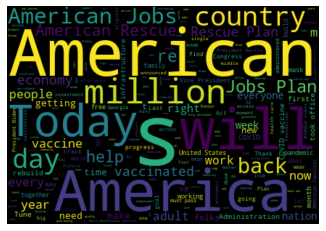

<Figure size 1080x720 with 0 Axes>

In [23]:
allWords = ' '.join( [twts for twts in df['Tweets']])
wordCloud = WordCloud(width = 430, height = 300, random_state = 21, max_font_size = 119).generate(allWords)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.figure(figsize=(15,10))

plt.show()

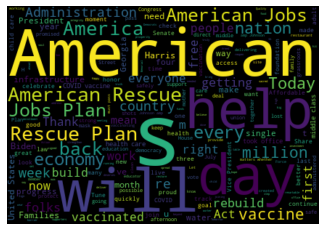

In [18]:
allWords = ' '.join( [twts for twts in positive['Tweets']])
wordCloud = WordCloud(width = 430, height = 300, random_state = 21, max_font_size = 119).generate(allWords)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()